In [1]:
%matplotlib inline

import os
import pandas as pd
import sys
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import warnings

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [3]:
pdfp = '/home/ngr4/project/perturb-seq/data/processed'
data_file = '/home/ngr4/project/perturb-seq/data/processed/mock_20sets_per_guide.npy'

['/home/ngr4/project/perturb-seq/data/processed/mock_20sets_per_guide.npy']

In [9]:
import random
import time
import math

from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
from scipy.stats import wasserstein_distance


from math import isnan
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity  # display as density curves

import torch
import torch.nn as nn
from torch.nn import init, Module, Parameter  # PyTorch syntax for optimization problems
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
# from geomloss import SamplesLoss
from sklearn.datasets import make_swiss_roll
from scipy.stats import wishart
from sklearn.utils import shuffle as util_shuffle

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Log2PI = float(np.log(2 * np.pi))

def log_normal(x, mean, log_var, eps=0.00001):
    z = - 0.5 * Log2PI
    return - (x - mean) ** 2 / (2. * torch.exp(log_var) + eps) - log_var / 2. + z


def log_standard_normal(x):
    z = - 0.5 * Log2PI
    return - x ** 2 / 2 + z

class DeepSet(nn.Module):

    def __init__(self, in_features, set_features):
        super(DeepSet, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ELU(inplace=True),
            nn.Linear(64, 256),
            nn.ELU(inplace=True),
            nn.Linear(256, set_features)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, 256),
            nn.ELU(inplace=True),
            nn.Linear(256, 128),
            nn.ELU(inplace=True),
            nn.Linear(128, 64),
            nn.ELU(inplace=True),
            nn.Linear(64, 32),
        )
        
        
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        return x
    
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).to(device).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).to(device).squeeze()

        u = torch.zeros_like(mu).to(device)
        v = torch.zeros_like(nu).to(device)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

      #  return cost, pi, C
        return cost

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=1):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None).to(device)

class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
           
        return x

    def __len__(self):
        return len(self.data)
    
# load data

D = np.load(data_file)
D_torch = torch.from_numpy(D).view(640,100,10)
dataset = MyDataset(D_torch)
loader = DataLoader(dataset, batch_size=16, shuffle=True)



In [12]:
W = np.eye(D_torch.shape[0])
for i in range(D_torch.shape[0])
    for j in range(i+1, D_torch.shape[0]):
        w_ij = sinkhorn(D_torch[i, :, :],D_torch[j, :, :]).item()
        W[i, j] = w_ij
        W[j, i] = w_ij
        del w_ij

In [36]:
# row stochastic normalization
W_normalized = W / W.sum(axis=1)

In [78]:
import phate
import umap
# import graphtools as gt

# G = gt.Graph(data=W - np.eye(D_torch.shape[0],
#              precomputed='adjacency',
#              use_pygsp=True)

# phate_op = phate.PHATE(knn_dist='precomputed',
#                        gamma=0)

if False:
    # with 0s in diagonal
    data_phate = phate.PHATE(knn_dist='precomputed',gamma=0).fit_transform(W - np.eye(D_torch.shape[0]))
    data_umap = umap.UMAP(metric='precomputed').fit_transform(W - np.eye(D_torch.shape[0]))
else:
    # with 1s in diagonal
    data_phate = phate.PHATE(knn_dist='precomputed',gamma=0).fit_transform(W)
    data_umap = umap.UMAP(metric='precomputed').fit_transform(W)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 640 cells.
  Calculating graph and diffusion operator...
  Calculating optimal t...
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.41 seconds.
Calculated PHATE in 0.52 seconds.


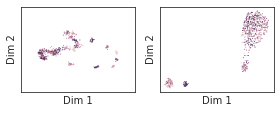

In [79]:
pfp = '/home/ngr4/project/perturb-seq/results/'

fig, ax = plt.subplots(1, 2, figsize=(4, 1.67))
sns.scatterplot(x=data_phate[:, 0], y=data_phate[:,1], 
                hue=list(range(32))*20,
                ax=ax[0], linewidth=0, s=1, 
                rasterized=True)
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:,1], 
                hue=list(range(32))*20,
                ax=ax[1], linewidth=0, s=1, 
                rasterized=True)
for single_ax in ax:
    single_ax.set_xlabel('Dim 1')
    single_ax.set_ylabel('Dim 2')
    single_ax.set_xticks([])
    single_ax.set_yticks([])
    single_ax.legend().set_visible(False)
    
fig.tight_layout()

fig.savefig(os.path.join(pfp, 'phateumap_perturbseq_mock_sinkhorn_by_guide.png'), dpi=600, bbox_inches='tight')